In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from forgetting_transformer.model.forgetting_transformer.glu_linear import glu_fwd
prefix = "relu"
id =12
with open(f"tensor/{prefix}/{id}_ctx_gate.pkl", "rb") as f:
    ctx_gate = pickle.load(f) #B, head_num, seq_length
with open(f"tensor/{prefix}/{id}_pos_gate.pkl", "rb") as f:
    pos_gate = pickle.load(f) #B, head_num, seq_length
ctx_lambda = torch.cumsum(ctx_gate, dim=-1, dtype=ctx_gate.dtype).float().cpu().numpy()
pos_lambda = torch.cumsum(pos_gate, dim=-1, dtype=ctx_gate.dtype).float().cpu().numpy()
for i in range(ctx_lambda.shape[1]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 左图：ctx_lambda
    axes[0].plot(range(ctx_lambda.shape[-1]), ctx_lambda[0, i], color="blue")
    axes[0].set_title(f"Head {i} - ctx_lambda")
    axes[0].set_xlabel("Sequence Position")
    axes[0].set_ylabel("Lambda Value")
    axes[0].grid(True)

    # 右图：pos_lambda
    axes[1].plot(range(ctx_lambda.shape[-1]), pos_lambda[0, i], color="orange")
    axes[1].set_title(f"Head {i} - pos_lambda")
    axes[1].set_xlabel("Sequence Position")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from forgetting_transformer.model.forgetting_transformer.glu_linear import glu_fwd

def sparsity(x, threshold=1e-3):
    return np.mean(np.abs(x) < threshold)
id = 12
with open(f"tensor/760m/{id}_og.pkl", "rb") as f:
    o_fgate = pickle.load(f)
with open(f"tensor/760m/{id}_o.pkl", "rb") as f:
    o = pickle.load(f) #B, T, D
threshold = 1e-3
o_gated = glu_fwd(o, o_fgate).cpu().numpy()
o = o.cpu().numpy()
print(f"Sparsity of o: {sparsity(o):.4f}")
print(f"Sparsity of o_gated: {sparsity(o_gated):.4f}")
plt.figure(figsize=(8, 5))
plt.hist(np.abs(o).flatten(), bins=100, alpha=0.5, label='|o|')
plt.hist(np.abs(o_gated).flatten(), bins=100, alpha=0.5, label='|o_gated|')
plt.axvline(threshold, color='red', linestyle='--', label=f'threshold={threshold}')
plt.yscale('log')
plt.legend()
plt.title("Distribution of |o| and |o_gated|")
plt.xlabel("Absolute Value")
plt.ylabel("Count (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()
for i in range(4):
    o_i = o[i, :, :]
    o_gated_i = o_gated[i, :, :]
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im0 = axs[0].imshow(o_i, aspect='auto', interpolation='nearest', cmap='viridis')
    axs[0].set_title(f"Original o[{i}]")
    axs[0].set_xlabel("Dim")
    axs[0].set_ylabel("Token ID")
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(o_gated_i, aspect='auto', interpolation='nearest', cmap='viridis')
    axs[1].set_title(f"Gated o[{i}]")
    axs[1].set_xlabel("Dim")
    axs[1].set_ylabel("Token ID")
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    plt.suptitle(f"Batch {i}: Original vs Gated Output", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import pickle
import matplotlib.pyplot as plt

# for id in range(23):
#     with open(f"tensor/{id}_gk.pkl", "rb") as f:
#         log_fgate = pickle.load(f)
#     log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()

prefix = "shift"
# i = 0
# j = 3
total = 0
for id in range(24):
    with open(f"tensor/{prefix}/{id}_gk.pkl", "rb") as f:
        log_fgate = pickle.load(f)
    log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
    for i in range(log_lambda.size(0)):
        for j in range(log_lambda.size(1)):
            if log_lambda[i][j].min() >= -20:
                total += 1
print(total)

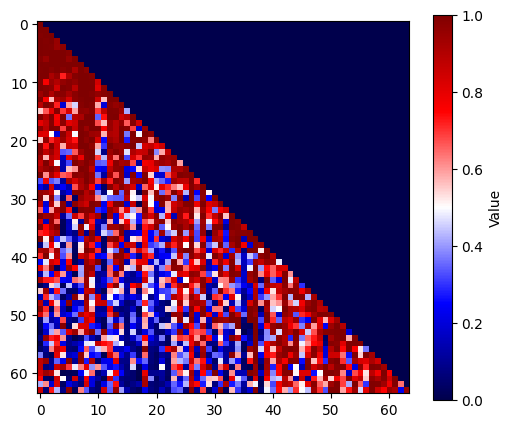

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import pickle
import matplotlib.pyplot as plt

# for id in range(23):
#     with open(f"tensor/{id}_gk.pkl", "rb") as f:
#         log_fgate = pickle.load(f)
#     log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
id = 7
prefix = "silu"
i = 0
j = 7
with open(f"tensor/{prefix}/{id}_q.pkl", "rb") as f:
    q = pickle.load(f)
with open(f"tensor/{prefix}/{id}_k.pkl", "rb") as f:
    k = pickle.load(f)
with open(f"tensor/{prefix}/{id}_pos_gate.pkl", "rb") as f:
    pos_fgate = pickle.load(f)
with open(f"tensor/{prefix}/{id}_ctx_gate.pkl", "rb") as f:
    ctx_fgate = pickle.load(f)
log_lambda = torch.cumsum(pos_fgate + ctx_fgate, dim=-1, dtype=pos_fgate.dtype).float()
S = q @ k.transpose(-2, -1) + (log_lambda.unsqueeze(-1) - log_lambda.unsqueeze(-2))
mask = torch.triu(torch.ones((S.shape[2], S.shape[2]), device=S.device, dtype=torch.bool), diagonal=1)
S.masked_fill_(mask, float('-inf'))  # inplace
S = S.softmax(dim = -1)
S_np = (torch.nn.functional.max_pool2d(S, kernel_size=128)[i][j]).cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(S_np, cmap='seismic', interpolation='nearest')
plt.colorbar(label='Value')
plt.show()

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import pickle
import matplotlib.pyplot as plt

# for id in range(23):
#     with open(f"tensor/{id}_gk.pkl", "rb") as f:
#         log_fgate = pickle.load(f)
#     log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
id = 7


prefix = "relu"
# i = 0
# j = 3
with open(f"tensor/{prefix}/{id}_q.pkl", "rb") as f:
    q = pickle.load(f)
with open(f"tensor/{prefix}/{id}_k.pkl", "rb") as f:
    k = pickle.load(f)
with open(f"tensor/{prefix}/{id}_pos_gate.pkl", "rb") as f:
    pos_fgate = pickle.load(f)
with open(f"tensor/{prefix}/{id}_ctx_gate.pkl", "rb") as f:
    ctx_fgate = pickle.load(f)
pos_lambda = torch.cumsum(pos_fgate, dim=-1, dtype=pos_fgate.dtype).float()
ctx_lambda = torch.cumsum(ctx_fgate, dim=-1, dtype=pos_fgate.dtype).float()
log_lambda = pos_lambda + ctx_lambda
D = log_lambda.unsqueeze(-1) - log_lambda.unsqueeze(-2)
S = q @ k.transpose(-2, -1) + D
B, H, N, _ = S.shape
mask = torch.triu(torch.ones((N, N), device=S.device, dtype=torch.bool), diagonal=1)
S.masked_fill_(mask, float('-inf'))  # inplace
D.masked_fill_(mask, float('-inf'))
D = D.exp() 
S = S.softmax(dim = -1)
B = S.size(0)
H = S.size(1)
S_np = S.cpu().numpy()
D_np = D.cpu().numpy()
pos_lambda_np = pos_lambda.cpu().numpy()
ctx_lambda_np = ctx_lambda.cpu().numpy()
total_lambda_np = log_lambda.cpu().numpy()
for i in range(B):
    for j in range(H):
        S_np_i_j = S_np[i][j]
        D_np_i_j = D_np[i][j]
        pos_lambda_np_i_j = pos_lambda_np[i][j]
        ctx_lambda_np_i_j = ctx_lambda_np[i][j]
        total_lambda_np_i_j = total_lambda_np[i][j]
        fig, axs = plt.subplots(1, 5, figsize=(22, 5))  # 一行三列子图

        im0 = axs[0].imshow(S_np_i_j, cmap='coolwarm', interpolation='nearest')
        axs[0].set_title(f"S[{i}][{j}]")
        fig.colorbar(im0, ax=axs[0], orientation='vertical', label='Value')

        im1 = axs[1].imshow(D_np_i_j, cmap='coolwarm', interpolation='nearest')
        axs[1].set_title(f"D[{i}][{j}]")
        fig.colorbar(im1, ax=axs[1], orientation='vertical', label='Value')

        axs[2].plot(ctx_lambda_np_i_j)
        axs[2].set_title(f"ctx_lambda[{i}][{j}]")
        axs[2].grid(True)

        axs[3].plot(pos_lambda_np_i_j)
        axs[3].set_title(f"pos_lambda[{i}][{j}]")
        axs[3].grid(True)

        axs[4].plot(total_lambda_np_i_j)
        axs[4].set_title(f"total_lambda[{i}][{j}]")
        axs[4].grid(True)

        plt.tight_layout()
        # plt.show()
        plt.savefig(f"{prefix}_{i}_{j}.png")
        print(f"{prefix}_{i}_{j}.png")

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt
# for id in range(23):
#     with open(f"tensor/{id}_gk.pkl", "rb") as f:
#         log_fgate = pickle.load(f)
#     log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
id = 12
with open(f"tensor/{id}_gk.pkl", "rb") as f:
    log_fgate = pickle.load(f)
log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
B = log_lambda.size(0)
H = log_lambda.size(1)
log_lambda = log_lambda.cpu().numpy()
for i in range(B):
    for j in range(H):
        log_lambda_np = log_lambda[i][j]
        plt.figure(figsize=(6, 5))
        plt.plot(log_lambda_np)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt
# for id in range(23):
#     with open(f"tensor/{id}_gk.pkl", "rb") as f:
#         log_fgate = pickle.load(f)
#     log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
id = 12
with open(f"tensor/{id}_q.pkl", "rb") as f:
    q = pickle.load(f)
with open(f"tensor/{id}_k.pkl", "rb") as f:
    k = pickle.load(f)
with open(f"tensor/{id}_gk.pkl", "rb") as f:
    log_fgate = pickle.load(f)
log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
D = log_lambda.unsqueeze(-1) - log_lambda.unsqueeze(-2)
S = q @ k.transpose(-2, -1) + D
mask = torch.triu(torch.ones_like(S), diagonal=1)
S = S.masked_fill(mask.bool(), float('-inf'))
B = S.size(0)
H = S.size(1)
S_np = S.cpu().numpy()
for i in range(B):
    for j in range(H):
        print(S[i][j].flatten().topk(20).values)
        S_np_i_j = S_np[i][j]
        plt.figure(figsize=(6, 5))
        plt.imshow(S_np_i_j, cmap='coolwarm', interpolation='nearest')
        plt.colorbar(label='Value')
        plt.show()

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt
id = 16
with open(f"tensor/{id}_gk.pkl", "rb") as f:
    log_fgate = pickle.load(f)
log_lambda = torch.cumsum(log_fgate, dim=-1, dtype=log_fgate.dtype).float()
D = log_lambda.unsqueeze(-1) - log_lambda.unsqueeze(-2)
mask = torch.triu(torch.ones(D.shape, dtype=torch.bool, device=D.device), diagonal=1)
D.masked_fill_(mask, float('-inf'))
B = D.size(0)
H = D.size(1)
D = D.cpu().numpy()
for i in range(B):
    for j in range(H):
        D_np = D[i][j]
        plt.figure(figsize=(6, 5))
        plt.imshow(D_np, cmap='seismic', interpolation='nearest')
        plt.colorbar(label='Value')
        plt.show()